# NXP IMU

![](imu.jpg)

Our inertial measurement unit (IMU) contains 2 main chips:

### FXOS8700 3-Axis Accelerometer/Magnetometer

- ±2 g/±4 g/±8 g adjustable acceleration range
- ±1200 µT magnetic sensor range
- Output data rates (ODR) from 1.563 Hz to 800 Hz
- 14-bit ADC resolution for acceleration measurements
- 16-bit ADC resolution for magnetic measurements

### FXAS21002 3-Axis Gyroscope

- ±250/500/1000/2000°/s configurable range
- Output Data Rates (ODR) from 12.5 to 800 Hz
- 16-bit digital output resolution

# Earth's Magnetic Field

The intensity of the field is often measured in gauss (G), but is generally reported in nanoteslas (nT), with 1 G = 100,000 nT. A nanotesla is also referred to as a gamma ($\gamma$). The tesla is the SI unit of the Magnetic field, B. The Earth's field ranges between approximately 25,000 and 65,000 nT (0.25–0.65 G or 25-65 $\mu$T). By comparison, a strong refrigerator magnet has a field of about 10,000,000 nanoteslas (100 G).

| Prefix | Symbol | Decimal   |
|--------|--------|-----------|
| milli  | m      | $10^{-3}$ |
| micro  | $\mu$  | $10^{-6}$ |
| nano   | n      | $10^{-9}$ |

## Geographical Variation of the Field

![](world_field_map.jpg)


## Temperal Variation of the Field

The Earth's magnetic field is always changing and often change every 200k - 300k years.

![](earth_magnetic_field.gif)

## Noise

### Hard Iron Interference

So called hard iron interference is caused by static magnetic fields associated with the enviornment. For example, this could include any minor (or major) magnetism in the metal chassis or frame of a vehicle, any actual magnets such as speakers, etc... This interference pattern is unique to the environment but is constant. If you have your compass in an enclosure that is held together with metal screws even these relatively small amounts of ferromagnetic material can cause issues. If we consider the magnetic data circle, hard iron interference has the effect of shifting the entire circle away from the origin by some amount. The amount is dependent on any number of different factors and can be very large. The important part is that this shift is the same for all points in time so it can be calibrated out very easily with a numeric offset which is taken care of by the calibration process


To compensate and recenter, for each axis (x,y,z), we will calculate the mean offset ($\alpha$):

$$
\alpha_x = \frac{x_{max} + x_{min}}{2} \\
mag_{corrected} = mag_{raw} - \alpha_x
$$

### Soft Iron Interference

Soft iron interference is caused by distortion of the Earth's magnetic field due to materials in the environment. Think of it like electricity - the magnetic field is looking for the easiest path to get to where it is going. Since magnetic fields can flow more easily through ferromagnetic materials than air, more of the field will flow through the ferromagnetic material than you would expect if it were just air. This distortion effect causes the magnetic field lines to be bent sometimes quite a bit. Note that unlike hard iron interference which is the result of materials which actually have a magnetic field of their own, soft iron interference is caused by non-magnetic materials distorting the Earth's magnetic field. This type of interference has a squishing effect on the magnetic data circle turning it into more of an ellipsoid shape. The distortion in this case depends on the direction that the compass is facing. Because of this, the distortion cannot be calibrated out with a simple offset, more complicated math will still let the compass account for this type of interference though.

# Setup

Import libraries and define helper functions

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import numpy as np
import shelve
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from math import sin, cos, atan2, pi, sqrt, asin
from math import radians as deg2rad
from math import degrees as rad2deg

In [3]:
def read(filename, keys):
    """
    Reads in a data file and returns a hash.
    
    todo: automatically pull all keys?
    
    In:
        filename - name of file
        keys - array of key names to get from the database
    """
    db = shelve.open(filename)
    ans = {}
    for key in keys:
        ans[key] = db[key]

    db.close()
    return ans

In [25]:
def normalize(x, y, z):
    """Return a unit vector"""
    norm = sqrt(x * x + y * y + z * z)
    if norm > 0.0:
        inorm = 1/norm
        x *= inorm
        y *= inorm
        z *= inorm
    else:
        raise Exception('division by zero: {} {} {}'.format(x, y, z))
    return (x, y, z)

In [5]:
def plotArray(g, title=None):
    """
    Plots the x, y, and z components of a sensor.
    
    In:
        title - what you want to name something
        [[x,y,z],[x,y,z],[x,y,z], ...]
    Out:
        None
    """
    x = []
    y = []
    z = []
    for d in g:
        x.append(d[0])
        y.append(d[1])
        z.append(d[2])
        
    plt.subplot(3,1,1)
    plt.plot(x)
    plt.ylabel('x')
    plt.grid(True)
    if title:
        plt.title(title)
    
    plt.subplot(3,1,2)
    plt.plot(y)
    plt.ylabel('y')
    plt.grid(True)
    
    plt.subplot(3,1,3)
    plt.plot(z)
    plt.ylabel('z')
    plt.grid(True)

In [43]:
def getOrientation(accel, mag, deg=True):
    ax, ay, az = normalize(*accel)
    mx, my, mz = normalize(*mag)
    
    roll = atan2(ay, az)
    pitch = atan2(-ax, ay*sin(roll)+az*cos(roll))

    heading = atan2(
        mz*sin(roll) - my*cos(roll),
        mx*cos(pitch) + my*sin(pitch)*sin(roll) + mz*sin(pitch)*cos(roll)
    )

    if deg:
        roll *= 180/pi
        pitch *= 180/pi
        heading *= 180/pi

        heading = heading if heading >= 0.0 else 360 + heading
        heading = heading if heading <= 360 else heading - 360
    else:
        heading = heading if heading >= 0.0 else 2*pi + heading
        heading = heading if heading <= 2*pi else heading - 2*pi

    return (roll, pitch, heading)

In [33]:
def find_calibration(mag):
    """
    Go through the raw data and find the max/min for x, y, z
    """
    max_m = [-1000]*3
    min_m = [1000]*3
    for m in mag:
        for i in range(3):
            max_m[i] = m[i] if m[i] > max_m[i] else max_m[i]
            min_m[i] = m[i] if m[i] < min_m[i] else min_m[i]
    bias = [0]*3
    for i in range(3):
        bias[i] = (max_m[i] + min_m[i])/2
    return bias

def apply_calibration(data, bias):
    """
    Given the data and the bias, correct the data 
    """
    c_data = []
    for d in data:
        t = []
        for i in [0,1,2]:
            t.append(d[i]-bias[i])
        c_data.append(t)
            
    return c_data

In [27]:
def split(data):
    """
    Break out the x, y, and z into it's own array for plotting
    """
    xx = []
    yy = []
    zz = []
    for v in data:
        xx.append(v[0])
        yy.append(v[1])
        zz.append(v[2])
    return xx, yy, zz

def plotMagnetometer3D(data, title=None):
    x,y,z = split(data)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(x, y, z, '.b');
    ax.set_xlabel('$\mu$T')
    ax.set_ylabel('$\mu$T')
    ax.set_zlabel('$\mu$T')
    if title:
        plt.title(title);

def plotMagnetometer(data, title=None):
    x,y,z = split(data)
    plt.plot(x,y,'.b', x,z,'.r', z,y, '.g')
    plt.xlabel('$\mu$T')
    plt.ylabel('$\mu$T')
    plt.grid(True);
    if title:
        plt.title(title);

# Run Raw Compass Performance

First lets tumble around the imu and grab lots of data in ALL orientations.

In [64]:
cal = read('imu.dat', ['imu'])

In [65]:
def breakout_imu(data):
    print('imu length:', len(data['imu']))
    a = []
    m = []
    g = []
    ts = []
    for d in data['imu']:
        aa,mm,gg = d[0]
        timestamp = d[1]
        a.append(aa)
        m.append(mm)
        g.append(gg)
        ts.append(timestamp)
    print('duration:', ts[-1] - ts[0], 'sec')
    return a, m, g, ts

In [66]:
a, m, g, ts = breakout_imu(cal)

imu length: 1000
duration: 33.968228817 sec


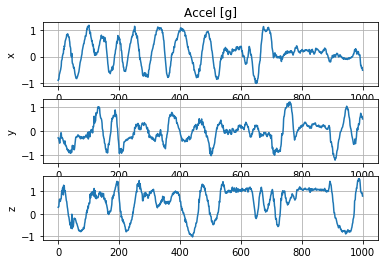

In [70]:
plotArray(a, 'Accel [g]')

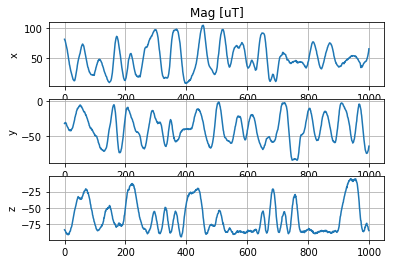

In [71]:
plotArray(m, 'Mag [uT]')

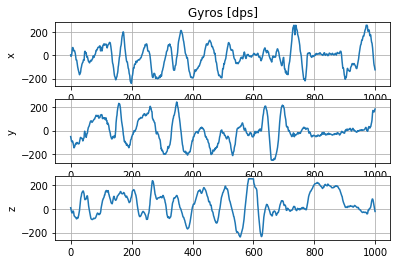

In [72]:
plotArray(g, 'Gyros [dps]')

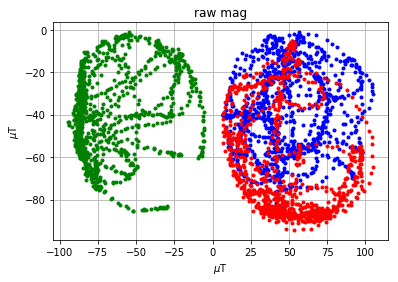

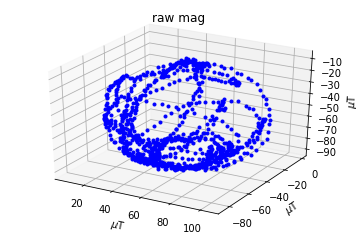

In [73]:
# now, ideally these should be an ellipsoid centered around 0.0
# but they aren't ... need to fix the bias (offset)
plotMagnetometer(m, 'raw mag')
plotMagnetometer3D(m, 'raw mag')

In [74]:
# so let's find the bias needed to correct the imu
bias = find_calibration(m)
print('bias', bias)

bias [55.7, -43.2, -49.85000000000001]


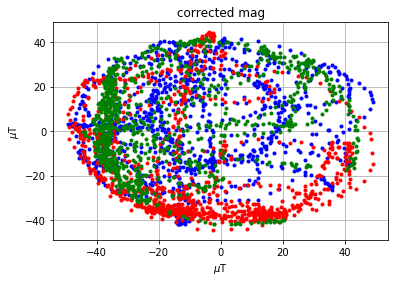

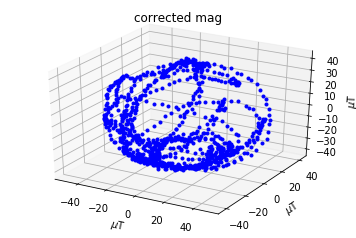

In [75]:
# now the data should be nicely centered around (0,0,0)
cm = apply_calibration(m, bias)
plotMagnetometer(cm, 'corrected mag')
plotMagnetometer3D(cm, 'corrected mag')

Now using this bias, we should get better performance.

# Check Calibration

imu length: 1000
duration: 33.9618752003 sec


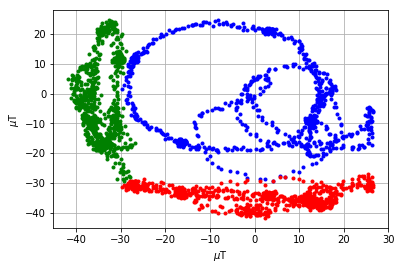

In [77]:
# read in new data and break it out
cal_check = read('check_cal.dat', ['imu'])
a, m, g, ts = breakout_imu(cal_check)

# apply correction in previous step
cm = apply_calibration(m, bias)
plotMagnetometer(cm)

timestep 0.0327670574188


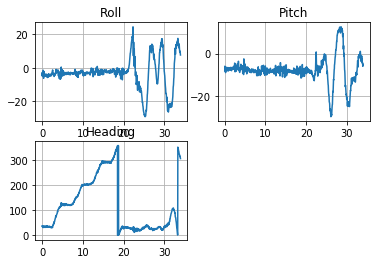

In [79]:
# Now let's run through the data and correct it
roll = []
pitch = []
heading = []

for accel, mag in zip(a, cm):
    r,p,h = getOrientation(accel, mag)
    roll.append(r)
    pitch.append(p)
    heading.append(h)
    
x_scale = [x-ts[0] for x in ts]
print('timestep', ts[1] - ts[0])

plt.subplot(2,2,1)
plt.plot(x_scale, roll)
plt.grid(True)
plt.title('Roll')

plt.subplot(2,2,2)
plt.plot(x_scale, pitch)
plt.grid(True)
plt.title('Pitch')

plt.subplot(2,2,3)
plt.plot(x_scale, heading)
plt.grid(True)
plt.title('Heading');

Now, this data was acquired with the imu starting off flat and slow rotated 360 degrees with stops around 90, 180, 270 from the starting position. At the end, I started wobbling/nutating (don't know how else to describe it) so you see the roll and pitch jump up ... there was some inadvertant change to heading during the end.

Now looking at the results, you can see I didn't start at 0 deg and there is approximately 4 movements about 90 degrees appart ... which is what I did.

# Notes

## macOS

In order for shelve to work, reinstalled python with:

    brew install python --with-berkeley-db@4

The issue is linux uses bsddb as the database and macOS doesn't ship with that databse installed. Thus you cannot read it. Eventually I will remove this requirement, but this test data might not change.

# References

- [Simple Calibration Routine](https://github.com/kriswiner/MPU6050/wiki/Simple-and-Effective-Magnetometer-Calibration)
- [Calibration Routine](http://www.sensorsmag.com/components/compensating-for-tilt-hard-iron-and-soft-iron-effects)
- [Hard/Soft Iron Effects](https://www.phidgets.com/docs/Magnetometer_Primer)
- [Wikipedia: Earth's magnetic field](https://en.wikipedia.org/wiki/Earth%27s_magnetic_field)
- [NASA: Earth's Pole Reversal](https://www.nasa.gov/topics/earth/features/2012-poleReversal.html)
- [Wikipedia: Tesla (unit)](https://en.wikipedia.org/wiki/Tesla_(unit))
- [C version](https://github.com/TobiasSimon/MadgwickTests/blob/master/MadgwickAHRS.c)


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.